In [76]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import yfinance as yf
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.metrics import mean_squared_error

In [77]:
# Define the path where the tokenizer and model are saved
load_directory = 'C:/Users/Clyden Pacheco/Documents/Models/twitter_roberta_sentiment'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(load_directory)
model = AutoModelForSequenceClassification.from_pretrained(load_directory)

In [78]:
# Override how Pandas Datareader reads data
yf.pdr_override()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Define the list of stocks you want to download
stocks = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS',
          'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS',
          'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
          'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
          'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS',
          'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LTIM.NS', 'LT.NS',
          'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS',
          'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS',
          'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS',
          'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']

# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year, today.month-5, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)

2024-01-20 00:00:00
2024-06-20 00:00:00


In [79]:
# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

stock = 'TCS.NS'

# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

# Download data from Yahoo Finance
df = yf.download(stock, start=start, end=end)

# Ticker for searching news
stockraw = stock[:-3]

# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage, 'html.parser')

# Extract titles and dates
titles = soup.find_all('a', class_='JtKRv')
datetimes = soup.find_all('time', class_='hvbAAd')

# Create lists to store extracted data
dates_list = []
titles_list = []

for title, datetime_tag in zip(titles, datetimes):
    # Remove leading/trailing whitespace from title
    title_text = title.text.strip()
    datetime_str = datetime_tag['datetime']

    # Parse datetime string
    formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')

    # Append data to respective lists
    dates_list.append(formatted_datetime.date())
    titles_list.append(title_text)

# Create DataFrame
df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)

# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

print(merged_df.tail(5))

# Isolating features for training
cols = list(merged_df)[1:8]

# Storing all data for scaling
df_for_scaling = merged_df[cols]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the numerical data
scaled_numerical_data = scaler.fit_transform(df_for_scaling)

# Create a new DataFrame for the scaled data
df_scaled = df_for_scaling.copy()
df_scaled[cols] = scaled_numerical_data

# Add a column for the stock ticker
df_scaled['Stock'] = stock

# Add all data to the following dataframe
all_stock_data = pd.concat([all_stock_data, df_scaled])

print(all_stock_data)

[*********************100%%**********************]  1 of 1 completed
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


         Date         Open         High          Low        Close  \
93 2024-06-12  3874.399902  3893.500000  3827.449951  3831.649902   
94 2024-06-13  3856.800049  3890.000000  3852.000000  3878.149902   
95 2024-06-14  3889.000000  3889.000000  3828.000000  3832.050049   
96 2024-06-18  3826.050049  3842.000000  3795.050049  3815.100098   
97 2024-06-19  3827.649902  3833.850098  3792.949951  3801.699951   

      Adj Close   Volume  Sentiments  
93  3831.649902  2177001   -0.103162  
94  3878.149902  1932323   -0.212121  
95  3832.050049  1860730   -0.064613  
96  3815.100098  1774045   -0.124759  
97  3801.699951  1509050   -0.045927  
        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.388161  0.370574  0.429120  0.341601   0.307924  0.181311    0.485292   
1   0.349345  0.271996  0.365671  0.311600   0.276387  0.185126    0.485292   
2   0.271518  0.227563  0.319727  0.254149   0.215999  0.140690    0.485292   
3   0.195633  0.147131  0.323399  0

C:\Users\Clyden Pacheco\AppData\Local\Temp\ipykernel_5504\4070322074.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Sentiments'].fillna(0, inplace=True)


In [80]:
df_for_training = all_stock_data.copy()

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments,Stock
0,0.388161,0.370574,0.429120,0.341601,0.307924,0.181311,0.485292,TCS.NS
1,0.349345,0.271996,0.365671,0.311600,0.276387,0.185126,0.485292,TCS.NS
2,0.271518,0.227563,0.319727,0.254149,0.215999,0.140690,0.485292,TCS.NS
3,0.195633,0.147131,0.323399,0.237188,0.198169,0.085861,0.485292,TCS.NS
4,0.208539,0.201668,0.333903,0.236367,0.197307,0.062775,0.485292,TCS.NS
...,...,...,...,...,...,...,...,...
93,0.338476,0.291319,0.402989,0.293088,0.310318,0.137926,0.420073,TCS.NS
94,0.304318,0.284453,0.444919,0.377895,0.400112,0.113902,0.351189,TCS.NS
95,0.366812,0.282491,0.403928,0.293817,0.311091,0.106872,0.444443,TCS.NS
96,0.244639,0.190289,0.347652,0.262904,0.278360,0.098361,0.406419,TCS.NS


In [81]:
# Convert to DataFrame
df = pd.DataFrame(df_for_training)

# Define all possible categories for the 'Stock' column
all_categories = sorted(stocks)

# Convert the 'Stock' column to a categorical type with the specified categories
df['Stock'] = pd.Categorical(df['Stock'], categories=all_categories)

# One hot encoding using pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['Stock'], dummy_na=False)
print(df_encoded)

cols = list(df_encoded)[7:57]


# Ensure the columns are integer type (0 and 1) instead of boolean
df_encoded[cols] = df_encoded[cols].astype(int)

# Print the one hot encoded DataFrame
print(df_encoded)

        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.388161  0.370574  0.429120  0.341601   0.307924  0.181311    0.485292   
1   0.349345  0.271996  0.365671  0.311600   0.276387  0.185126    0.485292   
2   0.271518  0.227563  0.319727  0.254149   0.215999  0.140690    0.485292   
3   0.195633  0.147131  0.323399  0.237188   0.198169  0.085861    0.485292   
4   0.208539  0.201668  0.333903  0.236367   0.197307  0.062775    0.485292   
..       ...       ...       ...       ...        ...       ...         ...   
93  0.338476  0.291319  0.402989  0.293088   0.310318  0.137926    0.420073   
94  0.304318  0.284453  0.444919  0.377895   0.400112  0.113902    0.351189   
95  0.366812  0.282491  0.403928  0.293817   0.311091  0.106872    0.444443   
96  0.244639  0.190289  0.347652  0.262904   0.278360  0.098361    0.406419   
97  0.247744  0.174301  0.344065  0.238464   0.252484  0.072341    0.456256   

    Stock_ADANIENT.NS  Stock_ADANIPORTS.NS  Stock_A

In [82]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 'Sentiments']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [83]:
# Dataset splitting
SPLIT = 1.00
(X_test, y_test) = singleStepSampler(df_encoded, 20)
print(X_test.shape)
print(y_test.shape)

(78, 20, 57)
(78, 7)


In [84]:
# Load the model
multivariate_lstm = load_model("C:/Users/Clyden Pacheco/Documents/Models/multivariate_lstm_model3.h5")

# Verify the loaded model
multivariate_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20, 200)           206400    
                                                                 
 dropout_6 (Dropout)         (None, 20, 200)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               120400    
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 327507 (1.25 MB)
Trainable params: 327507 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3/3 [==============================] - 1s 6ms/step


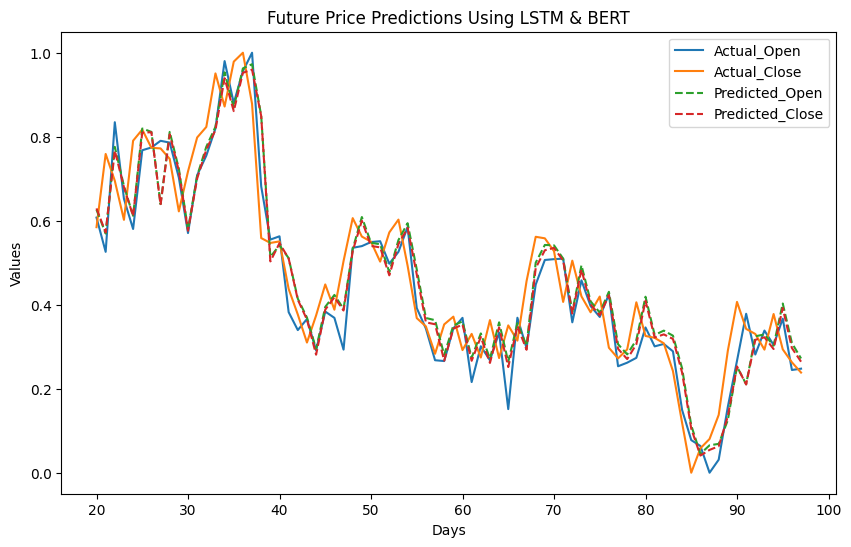

In [85]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
	'Predicted_Open': predicted_values[:, 0],
	'Predicted_Close': predicted_values[:, 1],
	'Actual_Open': y_test[:, 0],
	'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds

# Plot the actual values
#plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
plt.plot(d[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
#plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM & BERT')
plt.xlabel('Days')
plt.ylabel('Values')
ax.legend()
plt.show()

In [86]:
# Calculate RMSE for Open prices
rmse_open = mean_squared_error(d['Actual_Open'], d['Predicted_Open'], squared=False)

# Calculate RMSE for Close prices
rmse_close = mean_squared_error(d['Actual_Close'], d['Predicted_Close'], squared=False)

print(f'RMSE for Open prices: {rmse_open}')
print(f'RMSE for Close prices: {rmse_close}')

RMSE for Open prices: 0.05312863177549247
RMSE for Close prices: 0.08967858540227049


C:\Users\Clyden Pacheco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Clyden Pacheco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


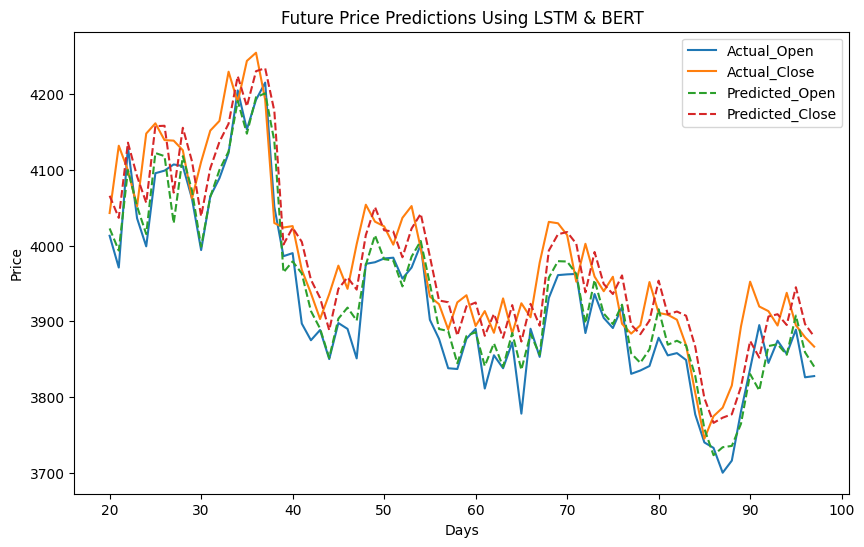

[[3869.6873 3909.355 ]
 [3855.8367 3895.1443]
 [3907.597  3944.9927]
 [3859.097  3896.3604]
 [3840.1567 3879.75  ]]


In [87]:
# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test)
predicted_values_inv = scaler.inverse_transform(predicted_values)

#print(predicted_values_inv)

# Create the DataFrame with inverse-transformed data
d = {
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
    'Actual_Open': y_test_inv[:, 0],
    'Actual_Close': y_test_inv[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
#plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
plt.plot(d[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
#plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM & BERT')
plt.xlabel('Days')
plt.ylabel('Price')
ax.legend()
plt.show()

print(predicted_values_inv[-5:,:2])

In [88]:
# Calculate RMSE for Open prices
rmse_open = mean_squared_error(d['Actual_Open'], d['Predicted_Open'], squared=False)

# Calculate RMSE for Close prices
rmse_close = mean_squared_error(d['Actual_Close'], d['Predicted_Close'], squared=False)

print(f'RMSE for Open prices: {rmse_open}')
print(f'RMSE for Close prices: {rmse_close}')

RMSE for Open prices: 27.37454223269612
RMSE for Close prices: 45.71365762077627


C:\Users\Clyden Pacheco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Clyden Pacheco\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0
1/1 [==============================] - 0s 26ms/step
1
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 32ms/step
3
2/2 [==============================] - 0s 4ms/step
4
2/2 [==============================] - 0s 3ms/step


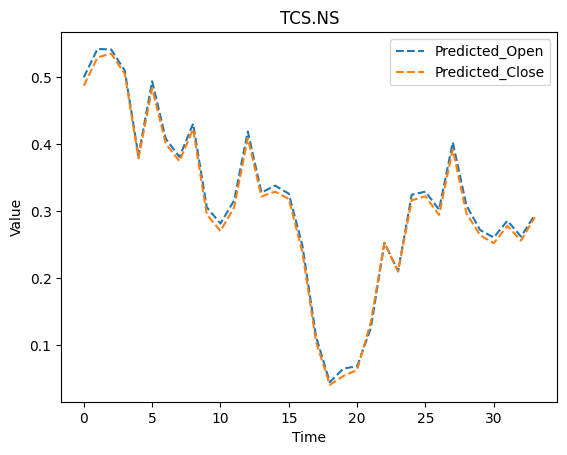

In [89]:
df_scaled_duplicate = df_encoded[-20:]
X_test_duplicate = X_test[-30:, :, :]
y_test_duplicate = y_test[-30:, :]

for i in range (5):
    print(i)
    
    # Make prediction
    predicted_values = multivariate_lstm.predict(X_test_duplicate)

    # Convert the predicted values into a dataframe
    df_predicted_values = pd.DataFrame(predicted_values)
    
    # Name the columns
    df_predicted_values.columns = list(df_scaled_duplicate.columns[:7])
    
    # Add stock column to perform one hot encoding
    df_predicted_values['Stock'] = stock
    
    # Convert the 'Stock' column to a categorical type with the specified categories
    df_predicted_values['Stock'] = pd.Categorical(df_predicted_values['Stock'], categories=all_categories)
    
    # One hot encoding using pd.get_dummies
    df_predicted_values_encoded = pd.get_dummies(df_predicted_values, columns=['Stock'], dummy_na=False)
    
    # Ensure the columns are integer type (0 and 1) instead of boolean
    cols = list(df_predicted_values_encoded)[7:57]
    df_predicted_values_encoded[cols] = df_predicted_values_encoded[cols].astype(int)
    
    # Select the last row of the predictions dataframe
    last_row = df_predicted_values_encoded.iloc[[-1]]
    
    # Append the last row to df_scaled_duplicate using pd.concat
    df_scaled_duplicate = pd.concat([df_scaled_duplicate, last_row], ignore_index=True)

    # Convert the data into a window
    (xVal2, yVal2) = singleStepSampler(df_scaled_duplicate, 20)

    # Delete the first row from the dataset
    df_scaled_duplicate = df_scaled_duplicate.drop(df_scaled_duplicate.index[0])

    # Append xVal2 to X_test_duplicate
    X_test_duplicate = np.concatenate([X_test_duplicate, xVal2], axis=0)

d2 = {
  'Predicted_Open': predicted_values[:, 0],
  'Predicted_Close': predicted_values[:, 1],
}
d2 = pd.DataFrame(d2)

# Plot predicted values with a dashed line
plt.plot(d2[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')
plt.legend()  # Add legend

# Show the plot
plt.title(f'{stock}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()  # Display the plot

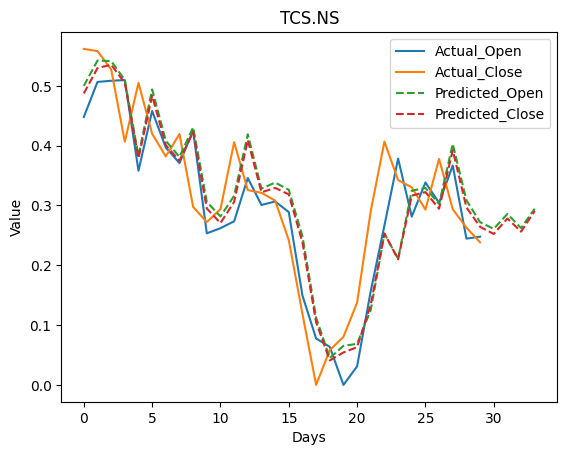

In [90]:
# Create a DataFrame for predicted values
d_predicted = {
  'Predicted_Open': predicted_values[:, 0],
  'Predicted_Close': predicted_values[:, 1],
}
d_predicted = pd.DataFrame(d_predicted)

# Create a DataFrame for actual values
d_actual = {
  'Actual_Open': y_test_duplicate[:, 0],
  'Actual_Close': y_test_duplicate[:, 1],
}
d_actual = pd.DataFrame(d_actual)

# Plot the actual values
plt.plot(d_actual[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d_predicted[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')
plt.legend()  # Add legend

# Show the plot
plt.title(f'{stock}')
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()  # Display the plot

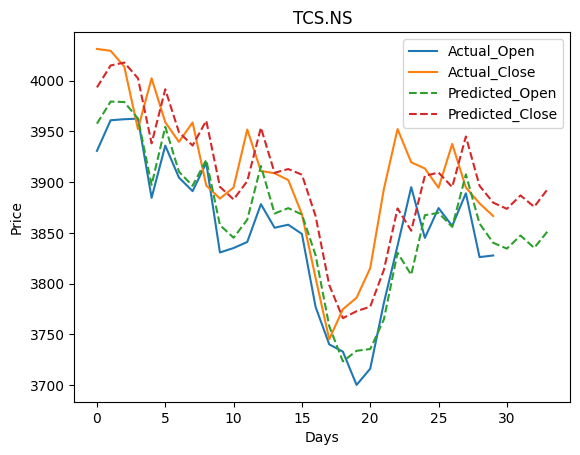

In [91]:
# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test_duplicate)
predicted_values_inv = scaler.inverse_transform(predicted_values)

# Create a DataFrame for predicted values
d_predicted = {
  'Predicted_Open': predicted_values_inv[:, 0],
  'Predicted_Close': predicted_values_inv[:, 1],
}
d_predicted = pd.DataFrame(d_predicted)

# Create a DataFrame for actual values
d_actual = {
  'Actual_Open': y_test_inv[:, 0],
  'Actual_Close': y_test_inv[:, 1],
}
d_actual = pd.DataFrame(d_actual)

# Plot the actual values
plt.plot(d_actual[['Actual_Open', 'Actual_Close']], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d_predicted[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')
plt.legend()  # Add legend

# Show the plot
plt.title(f'{stock}')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()  # Display the plot

In [92]:
d_predicted.tail(5)

,Predicted_Open,Predicted_Close
29,3840.156738,3879.750000
30,3834.417725,3873.651123
31,3847.310791,3886.851074
32,3835.117920,3875.618164
33,3851.771973,3893.370605
